# Определение перспективного тарифа для телеком-компании

Федеральный оператор "Мегалайн" предлагает клиентам два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег. 
В нашем распоряжении есть небольшая выборка по 500 абонентам за 2018 год: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений отправил каждый пользователь. Нужно проанализировать поведение клиентов и сделать выводы о расходах абонентов на разных тарифах, определить как отличается средняя выручка с абонента в зависимости от тарифа, а также региона.

Состав таблиц:
- users (информация о пользователях)
- calls (информация о звонках)
- messages (информация об SMS)
- internet (информация об интернет-сессиях)
- tariffs (информация о тарифах)

Примечание по тарификации:
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

План исследования:
1. Подготовка данных:
    - исправление типов и др.ошибок, очистка данных;
    - расчет для каждого пользователя за месяц: количества и длительности звонков, количества сообщений, объем трафика, выручки.
2. Анализ данных: сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Построение распределений, рассчет среднего, дисперсии и стандартного отклонения.
3. Проверка гипотез:
    - средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
    - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

## Изучение данных из файлов


In [1]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
pd.set_option('display.float_format', '{:,.2f}'.format)

In [2]:
#Загрузка и просмотр базовой информации по таблицам
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

display(calls.sample(10, random_state=1))
calls.info()
display(internet.sample(10, random_state=1))
internet.info()
display(messages.sample(10, random_state=1))
messages.info()
display(tariffs)
tariffs.info()
display(users.sample(10, random_state=1))
users.info()
#display(users[~users.churn_date.isna()])

,id,call_date,duration,user_id
26953,1066_374,2018-08-26,0.00,1066
66122,1168_1273,2018-03-28,16.05,1168
67325,1171_350,2018-09-14,6.23,1171
74643,1186_465,2018-09-02,0.79,1186
192311,1472_124,2018-05-04,5.94,1472
47375,1118_664,2018-10-24,13.41,1118
91143,1227_563,2018-08-03,15.15,1227
3818,1010_67,2018-08-16,14.29,1010
182822,1454_574,2018-09-23,9.98,1454
187346,1463_0,2018-12-05,10.63,1463


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
35745,35745,1124_125,122.45,2018-12-03,1124
18383,18383,1064_102,320.60,2018-12-19,1064
59774,59774,1203_22,605.96,2018-06-17,1203
56317,56317,1188_123,781.73,2018-05-08,1188
52231,52231,1176_386,150.98,2018-08-20,1176
20276,20276,1068_26,389.65,2018-12-04,1068
82748,82748,1281_64,841.89,2018-11-07,1281
129266,129266,1431_300,461.23,2018-11-26,1431
46783,46783,1160_75,0.00,2018-08-15,1160
48492,48492,1168_260,336.06,2018-07-28,1168


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,id,message_date,user_id
45696,1197_26,2018-12-31,1197
66091,1282_523,2018-11-30,1282
18743,1082_184,2018-10-18,1082
33759,1146_557,2018-12-22,1146
11403,1048_49,2018-09-27,1048
97793,1401_125,2018-08-10,1401
406,1000_406,2018-12-29,1000
71393,1302_221,2018-10-23,1302
103004,1420_11,2018-12-12,1420
53795,1238_208,2018-10-08,1238


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
304,1304,68,NaN,Владимир,Илья,Соловьёв,2018-11-05,ultra
340,1340,50,NaN,Пенза,Тимофей,Алютин,2018-01-30,smart
47,1047,67,NaN,Саратов,Милица,Меркулова,2018-10-29,smart
67,1067,45,NaN,Москва,Юзефа,Абашкина,2018-04-09,smart
479,1479,40,NaN,Хабаровск,Игорь,Богданов,2018-07-03,smart
485,1485,34,NaN,Киров,Таисия,Сухова,2018-12-29,ultra
310,1310,28,NaN,Уфа,Рудольф,Нестеров,2018-03-22,ultra
31,1031,66,NaN,Москва,Лаврентий,Тимофеев,2018-11-02,smart
249,1249,25,NaN,Курск,Изольда,Авдушева,2018-08-14,smart
90,1090,54,2018-12-03,Череповец,Екатерина,Астафьева,2018-10-11,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [3]:
#Проверим данные на дубликаты
print('Кол-во дубликатов в calls:',calls.duplicated().sum())
print('Кол-во дубликатов id в calls:',calls.id.duplicated().sum())
print('Кол-во дубликатов в internet:',internet.duplicated().sum())
print('Кол-во дубликатов id в internet:',internet.id.duplicated().sum())
print('Кол-во дубликатов в messages:',messages.duplicated().sum())
print('Кол-во дубликатов id в messages:',messages.id.duplicated().sum())
print('Кол-во дубликатов id в users:',users.user_id.duplicated().sum())
print()

Кол-во дубликатов в calls: 0
Кол-во дубликатов id в calls: 0
Кол-во дубликатов в internet: 0
Кол-во дубликатов id в internet: 0
Кол-во дубликатов в messages: 0
Кол-во дубликатов id в messages: 0
Кол-во дубликатов id в users: 0



### Вывод

Даты во всех таблицах записаны как строка. Типы числовых полей можно оптимизировать ради уменьшения использования памяти таблицами.
В таблице internet есть техническое поле Unamed:0, которое можно убрать.

В таблице users есть ушедшие от оператора абоненты. Для упрощения вычислений сделаем предположение, что корректировки по расходам абонентов за неполные месяцы начала и завершения обслуживания не требуются, поскольку не искажают картину распределений.

Дубликатов в таблицах не обнаружено.

## Подготовка данных

In [4]:

#Таблица calls
#Заменим типы данных
calls.call_date = pd.to_datetime(calls.call_date)
calls.user_id = calls.user_id.astype('int32')

#Таблица internet:
    #Заменим типы данных
internet.session_date = pd.to_datetime(internet.session_date)
internet.user_id = internet.user_id.astype('int32')
    #Удалим лишнюю колонку
try:
    internet.drop('Unnamed: 0', axis=1, inplace=True)
except:
    print('Columns already deleted')
    print()
    

#Таблица messages
    #Заменим типы данных
messages.message_date = pd.to_datetime(messages.message_date)
messages.user_id = messages.user_id.astype('int32')


#Таблица users
    #Заменим типы данных
users.reg_date = pd.to_datetime(users.reg_date)
users.churn_date = pd.to_datetime(users.churn_date)
users.user_id = users.user_id.astype('int32')
users.age = users.age.astype('int8')


In [5]:
#Добавим колонки с месяцем
calls['month'] = calls.call_date.dt.month.astype('int8')
#calls['year'] = calls.call_date.dt.year
#display(calls.year.value_counts())
internet['month'] = internet.session_date.dt.month.astype('int8')
#internet['year'] = internet.session_date.dt.year
#display(internet.year.value_counts())
messages['month'] = messages.message_date.dt.month.astype('int8')
#messages['year']= messages.message_date.dt.year
#display(messages.year.value_counts())

calls.info()
print()
messages.info()
print()
internet.info()
print()
users.info()
print()

#Рассчитаем кол-во и длительность звонков по абонентам
calls_stat = calls.pivot_table(index=['user_id', 'month'], values = 'duration', aggfunc=('count', 'sum'))
calls_stat.columns = ['calls', 'calls_sum']
display(calls_stat.head(10))
#Рассчитаем кол-во сообщений
messages_stat = calls.pivot_table(index=['user_id', 'month'], values = 'id', aggfunc=('count'))
messages_stat.columns = ['messages']
display(messages_stat.head(10))
#Рассчитаем трафик
internet_stat = internet.pivot_table(index=['user_id', 'month'], values = 'mb_used', aggfunc=('sum'))
display(internet_stat.head(10))

#Объединим данные в одну таблицу
users_stat = calls_stat.merge(messages_stat, how = 'outer', left_index = True, right_index = True)\
.merge(internet_stat, how='outer', left_index=True, right_index=True).reset_index()
#Добавим тарифный план и город
users_sub = users[['user_id', 'tariff', 'city']]
users_stat = users_stat.merge(users_sub, how='outer', left_on='user_id', right_on='user_id')

#Округлим значения до большего
users_stat.calls_sum = np.ceil(users_stat.calls_sum)
users_stat.mb_used = np.ceil(users_stat.mb_used)
users_stat.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 5 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int32
month        202607 non-null int8
dtypes: datetime64[ns](1), float64(1), int32(1), int8(1), object(1)
memory usage: 5.6+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 4 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int32
month           123036 non-null int8
dtypes: datetime64[ns](1), int32(1), int8(1), object(1)
memory usage: 2.5+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-

calls  calls_sum
user_id month                  
1000    5         22     150.06
        6         43     158.90
        7         47     318.80
        8         52     389.87
        9         58     440.14
        10        57     328.45
        11        43     319.04
        12        46     312.98
1001    11        59     408.12
        12        63     391.34

messages
user_id month          
1000    5            22
        6            43
        7            47
        8            52
        9            58
        10           57
        11           43
        12           46
1001    11           59
        12           63

mb_used
user_id month          
1000    5      2,253.49
        6     23,233.77
        7     14,003.64
        8     14,055.93
        9     14,568.91
        10    14,702.49
        11    14,756.47
        12     9,817.61
1001    11    18,429.34
        12    14,036.66

,user_id,month,calls,calls_sum,messages,mb_used,tariff,city
0,1000,5.00,22.00,151.00,22.00,"2,254.00",ultra,Краснодар
1,1000,6.00,43.00,159.00,43.00,"23,234.00",ultra,Краснодар
2,1000,7.00,47.00,319.00,47.00,"14,004.00",ultra,Краснодар
3,1000,8.00,52.00,390.00,52.00,"14,056.00",ultra,Краснодар
4,1000,9.00,58.00,441.00,58.00,"14,569.00",ultra,Краснодар
5,1000,10.00,57.00,329.00,57.00,"14,703.00",ultra,Краснодар
6,1000,11.00,43.00,320.00,43.00,"14,757.00",ultra,Краснодар
7,1000,12.00,46.00,313.00,46.00,"9,818.00",ultra,Краснодар
8,1001,11.00,59.00,409.00,59.00,"18,430.00",smart,Москва
9,1001,12.00,63.00,392.00,63.00,"14,037.00",smart,Москва


In [6]:
users_stat.user_id.nunique()

500

In [7]:
#Добавим расчет месячной выручки с абонента

def monthly_spend(calls_sum, messages, mb_used, tariff):
    #Retrieve the tariff data for the user
    tariff = tariffs[tariffs.tariff_name == tariff].iloc[0]
    
    calls_sum_over_limit = max(0, (calls_sum - tariff.minutes_included))
    messages_over_limit = max(0, (messages - tariff.messages_included))
    gb_over_limit = max(0, np.ceil((mb_used - tariff.mb_per_month_included)/1024))
    total = tariff.rub_monthly_fee + calls_sum_over_limit*tariff.rub_per_minute + messages_over_limit*tariff.rub_per_message + gb_over_limit*tariff.rub_per_gb    
    
    return total

users_stat['paid'] = np.vectorize(monthly_spend)(users_stat['calls_sum'], users_stat['messages'], users_stat['mb_used'], users_stat['tariff'])
users_stat.head(10)


,user_id,month,calls,calls_sum,messages,mb_used,tariff,city,paid
0,1000,5.00,22.00,151.00,22.00,"2,254.00",ultra,Краснодар,1950
1,1000,6.00,43.00,159.00,43.00,"23,234.00",ultra,Краснодар,1950
2,1000,7.00,47.00,319.00,47.00,"14,004.00",ultra,Краснодар,1950
3,1000,8.00,52.00,390.00,52.00,"14,056.00",ultra,Краснодар,1950
4,1000,9.00,58.00,441.00,58.00,"14,569.00",ultra,Краснодар,1950
5,1000,10.00,57.00,329.00,57.00,"14,703.00",ultra,Краснодар,1950
6,1000,11.00,43.00,320.00,43.00,"14,757.00",ultra,Краснодар,1950
7,1000,12.00,46.00,313.00,46.00,"9,818.00",ultra,Краснодар,1950
8,1001,11.00,59.00,409.00,59.00,"18,430.00",smart,Москва,1177
9,1001,12.00,63.00,392.00,63.00,"14,037.00",smart,Москва,589


In [8]:
users_stat['paid'].describe()

count   3,216.00
mean    1,526.30
std       798.81
min       550.00
25%       750.00
50%     1,623.50
75%     1,950.00
max     6,764.00
Name: paid, dtype: float64

### Вывод

Мы заменили тип колонок с датой на datetime, немного оптимизировали тип числовых полей, расчитали сумму звонков, сообщений и трафика с группировкой по абоненту и месяцу и посчитали, сколько абонент заплатил за этот месяц с учетом абонентской платы и оплаты сверх включенных в тариф пакетов. Свели все в единую таблицу и добавили информацию о городе абонента для дальнейшего анализа.

## Анализ данных

Описание данных по тарифу Smart:


,user_id,month,calls,calls_sum,messages,mb_used,paid
count,"2,230.00","2,229.00","2,223.00","2,223.00","2,223.00","2,228.00","2,230.00"
mean,"1,246.56",8.35,58.62,395.99,58.62,"16,216.15","1,285.89"
std,146.11,2.92,25.80,179.05,25.80,"5,861.74",818.10
min,"1,001.00",1.00,1.00,0.00,1.00,0.00,550.00
25%,"1,121.00",6.00,40.00,269.00,40.00,"12,650.00",583.00
50%,"1,240.00",9.00,60.00,399.00,60.00,"16,508.00","1,011.50"
75%,"1,376.00",11.00,76.00,516.00,76.00,"20,044.00","1,750.00"
max,"1,499.00",12.00,198.00,"1,355.00",198.00,"38,553.00","6,764.00"



Описание данных по тарифу Ultra:


,user_id,month,calls,calls_sum,messages,mb_used,paid
count,986.00,985.00,951.00,951.00,951.00,975.00,986.00
mean,"1,262.96",8.25,76.02,515.34,76.02,"19,668.99","2,070.03"
std,140.69,2.87,42.40,289.83,42.40,"9,943.07",376.02
min,"1,000.00",1.00,1.00,0.00,1.00,0.00,"1,950.00"
25%,"1,143.00",6.00,43.00,292.50,43.00,"12,008.50","1,950.00"
50%,"1,277.00",9.00,75.00,498.00,75.00,"19,395.00","1,950.00"
75%,"1,381.00",11.00,105.00,715.00,105.00,"26,897.00","1,950.00"
max,"1,495.00",12.00,244.00,"1,579.00",244.00,"49,746.00","4,800.00"



Среднее, дисперсия, и стандартное отклонение расходов на разных тарифах:


calls_sum                    mb_used                        messages  \
            mean    std       var      mean      std           var     mean   
tariff                                                                        
smart     395.99 179.05 32,058.09 16,216.15 5,861.74 34,360,010.97    58.62   
ultra     515.34 289.83 84,000.71 19,668.99 9,943.07 98,864,595.40    76.02   

                          paid                    
         std      var     mean    std        var  
tariff                                            
smart  25.80   665.44 1,285.89 818.10 669,293.19  
ultra  42.40 1,798.04 2,070.03 376.02 141,387.71

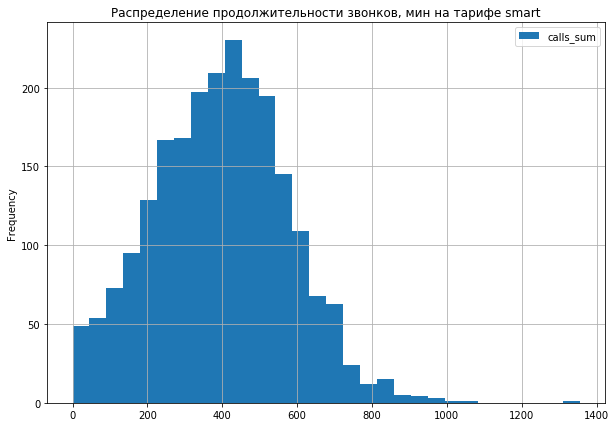

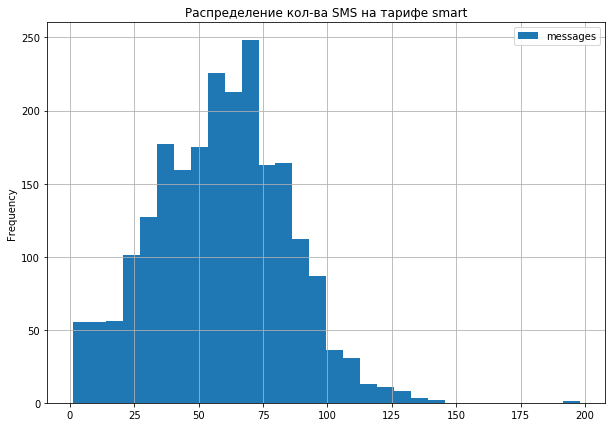

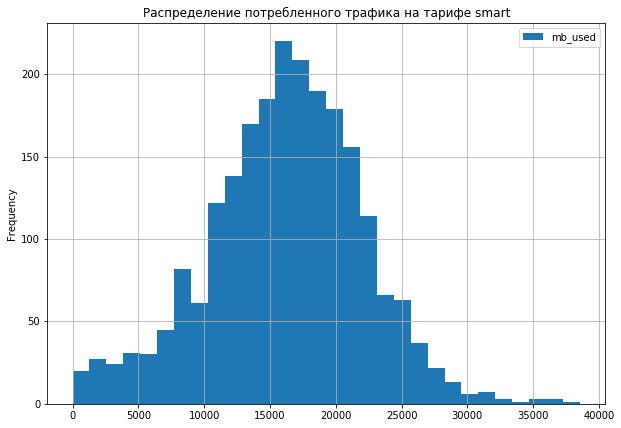

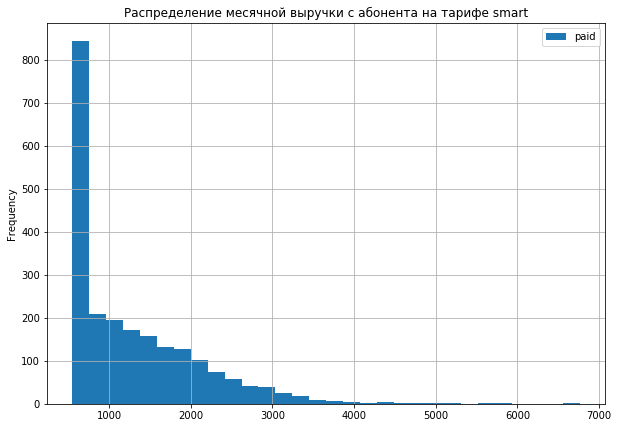

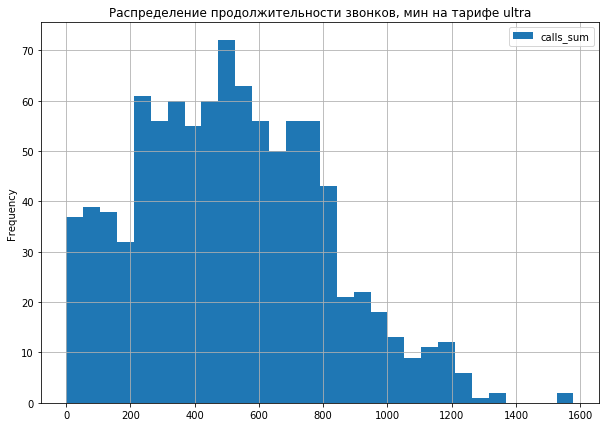

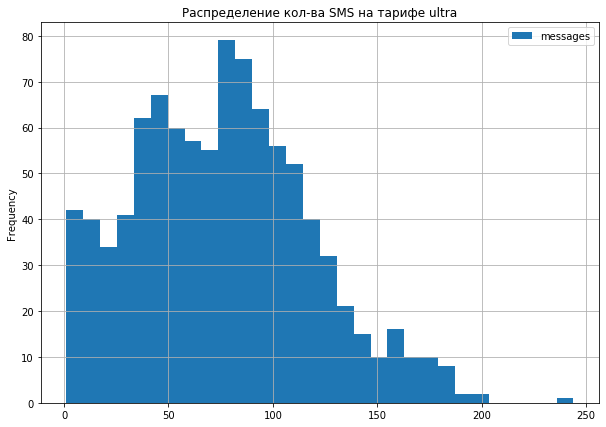

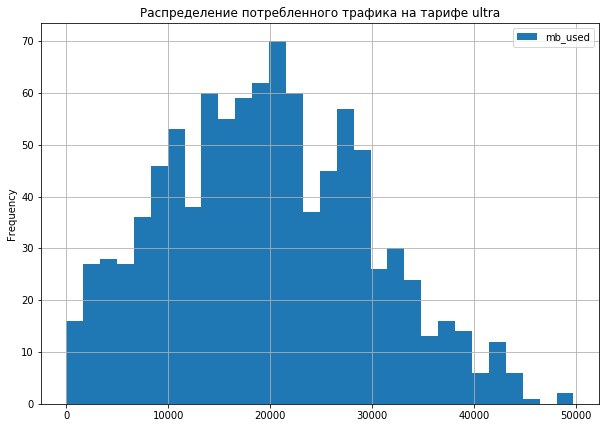

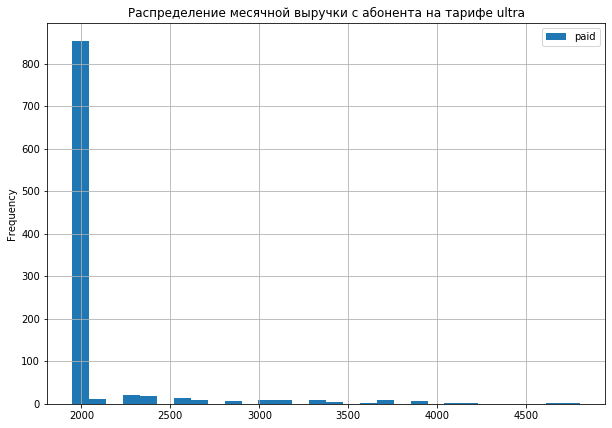

In [9]:
print('Описание данных по тарифу Smart:')
display(users_stat[users_stat.tariff == 'smart'].describe())
print()
print('Описание данных по тарифу Ultra:')
display(users_stat[users_stat.tariff == 'ultra'].describe())
print()

print('Среднее, дисперсия, и стандартное отклонение расходов на разных тарифах:')
display(users_stat.pivot_table(index = 'tariff', 
                               values = ['calls_sum', 'messages', 'mb_used', 'paid'], 
                               aggfunc=(np.var, np.std, np.mean)))
print()

#Построим распределения для разных тарифов
for name, tariff_stat in users_stat.groupby('tariff'):
    tariff_stat.plot(kind='hist', 
                      y = 'calls_sum', 
                      bins = 30,
                      grid=True, 
                      figsize=(10,7),
                      title = 'Распределение продолжительности звонков, мин на тарифе '+name)
    plt.show()
    #tariff_stat.hist(column='calls_sum', bins=30, density=True)
    
    tariff_stat.plot(kind='hist', 
                      y = 'messages',
                      bins=30,
                      grid=True,
                      figsize=(10,7),
                      title = 'Распределение кол-ва SMS на тарифе '+name)
    plt.show()
    
    tariff_stat.plot(kind='hist', 
                      y = 'mb_used',
                      bins=30,
                      grid=True,
                      figsize=(10,7),
                      title = 'Распределение потребленного трафика на тарифе '+name)
    plt.show()
    
    tariff_stat.plot(kind='hist',
                    y='paid',
                    bins=30,
                    grid=True,
                    figsize=(10,7),
                    title = 'Распределение месячной выручки с абонента на тарифе '+name)
    plt.show()
    

In [10]:
#Посчитаем параметры колонок для абонентов Москвы и других регионов

print('Описание данных по абонентам Москвы обоих тарифов:')
display(users_stat[(users_stat.city == 'Москва')].describe())
print()
print('Описание данных по абонентам регионов обоих тарифов:')
display(users_stat[(users_stat.city != 'Москва')].describe())
print()

print('Описание данных по абонентам Москвы Smart:')
display(users_stat[(users_stat.city == 'Москва') & (users_stat.tariff == 'smart')].describe())
print()
print('Описание данных по абонентам регионов Smart:')
display(users_stat[(users_stat.city != 'Москва') & (users_stat.tariff == 'smart')].describe())
print()

print('Описание данных по абонентам Москвы Ultra:')
display(users_stat[(users_stat.city == 'Москва') & (users_stat.tariff == 'ultra')].describe())
print()
print('Описание данных по абонентам регионов Ultra:')
display(users_stat[(users_stat.city != 'Москва') & (users_stat.tariff == 'ultra')].describe())
print()

Описание данных по абонентам Москвы обоих тарифов:


,user_id,month,calls,calls_sum,messages,mb_used,paid
count,611.00,611.00,610.00,610.00,610.00,611.00,611.00
mean,"1,268.87",8.43,65.54,444.04,65.54,"17,964.37","1,546.60"
std,137.53,2.89,33.11,227.73,33.11,"7,844.99",751.55
min,"1,001.00",1.00,1.00,1.00,1.00,366.00,550.00
25%,"1,171.00",6.00,42.00,287.25,42.00,"12,613.00",778.50
50%,"1,291.00",9.00,64.00,426.50,64.00,"17,538.00","1,776.00"
75%,"1,385.00",11.00,85.75,586.50,85.75,"22,115.50","1,950.00"
max,"1,490.00",12.00,188.00,"1,249.00",188.00,"44,297.00","5,267.00"



Описание данных по абонентам регионов обоих тарифов:


,user_id,month,calls,calls_sum,messages,mb_used,paid
count,"2,605.00","2,603.00","2,564.00","2,564.00","2,564.00","2,592.00","2,605.00"
mean,"1,247.54",8.29,63.43,428.82,63.43,"17,102.86","1,521.54"
std,145.99,2.91,32.57,224.19,32.57,"7,428.83",809.56
min,"1,000.00",1.00,1.00,0.00,1.00,0.00,550.00
25%,"1,120.00",6.00,41.00,271.75,41.00,"12,509.25",742.00
50%,"1,241.00",9.00,62.00,420.50,62.00,"16,874.50","1,589.00"
75%,"1,377.00",11.00,82.00,554.00,82.00,"21,242.00","1,950.00"
max,"1,499.00",12.00,244.00,"1,579.00",244.00,"49,746.00","6,764.00"



Описание данных по абонентам Москвы Smart:


,user_id,month,calls,calls_sum,messages,mb_used,paid
count,386.00,386.00,386.00,386.00,386.00,386.00,386.00
mean,"1,251.01",8.57,58.24,394.41,58.24,"16,018.59","1,239.17"
std,133.95,2.86,24.15,167.76,24.15,"5,611.91",752.53
min,"1,001.00",1.00,2.00,11.00,2.00,373.00,550.00
25%,"1,157.00",7.00,40.00,273.00,40.00,"12,552.75",580.00
50%,"1,260.00",9.00,57.50,386.00,57.50,"16,151.00",986.50
75%,"1,343.50",11.00,76.00,513.75,76.00,"19,848.25","1,695.25"
max,"1,490.00",12.00,128.00,968.00,128.00,"35,109.00","5,267.00"



Описание данных по абонентам регионов Smart:


,user_id,month,calls,calls_sum,messages,mb_used,paid
count,"1,844.00","1,843.00","1,837.00","1,837.00","1,837.00","1,842.00","1,844.00"
mean,"1,245.63",8.30,58.70,396.32,58.70,"16,257.55","1,295.67"
std,148.55,2.93,26.13,181.37,26.13,"5,913.39",831.03
min,"1,002.00",1.00,1.00,0.00,1.00,0.00,550.00
25%,"1,119.00",6.00,40.00,268.00,40.00,"12,718.00",583.00
50%,"1,232.00",9.00,60.00,404.00,60.00,"16,573.50","1,014.50"
75%,"1,378.00",11.00,76.00,516.00,76.00,"20,067.00","1,758.25"
max,"1,499.00",12.00,198.00,"1,355.00",198.00,"38,553.00","6,764.00"



Описание данных по абонентам Москвы Ultra:


,user_id,month,calls,calls_sum,messages,mb_used,paid
count,225.00,225.00,224.00,224.00,224.00,225.00,225.00
mean,"1,299.52",8.19,78.14,529.56,78.14,"21,302.46","2,074.00"
std,138.48,2.93,41.65,285.35,41.65,"9,785.24",350.10
min,"1,003.00",1.00,1.00,1.00,1.00,366.00,"1,950.00"
25%,"1,203.00",6.00,50.75,335.75,50.75,"13,753.00","1,950.00"
50%,"1,341.00",9.00,77.00,526.00,77.00,"21,471.00","1,950.00"
75%,"1,415.00",11.00,105.00,723.50,105.00,"28,678.00","1,950.00"
max,"1,476.00",12.00,188.00,"1,249.00",188.00,"44,297.00","4,050.00"



Описание данных по абонентам регионов Ultra:


,user_id,month,calls,calls_sum,messages,mb_used,paid
count,761.00,760.00,727.00,727.00,727.00,750.00,761.00
mean,"1,252.15",8.27,75.36,510.95,75.36,"19,178.95","2,068.86"
std,139.60,2.86,42.64,291.25,42.64,"9,944.13",383.55
min,"1,000.00",1.00,1.00,0.00,1.00,0.00,"1,950.00"
25%,"1,124.00",6.00,42.00,287.50,42.00,"11,779.75","1,950.00"
50%,"1,265.00",9.00,74.00,489.00,74.00,"18,623.50","1,950.00"
75%,"1,375.00",11.00,105.00,714.50,105.00,"25,984.00","1,950.00"
max,"1,495.00",12.00,244.00,"1,579.00",244.00,"49,746.00","4,800.00"


### Вывод

1. Ежемесячные суммы разговоров, сообщений и интернет-траффика на обоих тарифах имеют нормальное распределение. Наблюдается очень незначительная скошенность по тарифу Smart влево, а по Ultra - вправо.
2. Более половины абонентов Smart расходуют SMS и интернет сверх тарифных лимитов, и примерно треть расходует больше включенных в пакет бесплатных минут. Тогда как подавляющее большинство (~80%) абонентов плана Ultra укладываются в лимиты своего тарифа.
3. Посчитанная средняя выручка на выборках выше у Ultra (см. проверку гипотез ниже), тогда как максимальная вырочка наблюдается на выборке у абонентов на тарифe Smart.

## Проверка гипотез

In [11]:
#Проверим гипотезу о том, что средняя выручка тарифов отличается. H0 - средняя выручка равна
alpha = 0.05
results = st.ttest_ind(users_stat[users_stat.tariff == 'smart'].paid, users_stat[users_stat.tariff == 'ultra'].paid, equal_var = False)
print('p-value:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-value: 1.527869541198527e-252
Отвергаем нулевую гипотезу


In [12]:
#Проверим гипотезу о том, что средняя выручка абонентов из Москвы и других регионов различается. H0 - средняя выручка равна
alpha = 0.05
results = st.ttest_ind(users_stat[users_stat.city == 'Москва'].paid, users_stat[users_stat.city != 'Москва'].paid, equal_var = False)
print('p-value:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-value: 0.4652589993102004
Не получилось отвергнуть нулевую гипотезу


### Вывод

Выборки по абонентам двух разных тарифных планов можно рассматривать как выборки из разных генеральных совокупностей. Поэтому для их сравнения мы применяем метод scipy.stats.ttest_ind. Т.к. дисперсии по выручке в двух выборка разные, параметр equal_var = False.

**Гипотезы:** 
1. О выручке с абонентов на тарифных планах Smart и Ultra:
    - Нулевая гипотеза: Средняя выручка у абонентов на разных разных тарифных планов равна.
    - Альтернативная гипотеза: Cредняя выручка у абонентов на разных тарифных планах различается.
2. О выручке с абонентов из Москвы и других регионов.
    - Нулевая гипотеза: Средняя выручка у абонентов из Москвы и других регионов равна.
    - Альтернативная гипотеза: Средняя выручка у абонентов из Москвы и других регионов различается.

За критерий проверки нулевых гипотез примем критерий p-value < уровень статистической значимости.

**Результат проверки гипотез:**

**1. Средняя выручка тарифов различается и выше на тарифе Ultra.** Вероятность получить такое различие на выборках случайно - крайне мала.
**2. Гипотеза, что средняя выручка абонентов из Москвы и других регионов различается, не подтверждена.** Вероятность получить такое или большее различие в средних значниях (см выше) - почти 50%.

## Общий вывод

1. Среднемесячная выручка на абонента выше у абонентов тарифа Ultra.
2. Выручка у абонентов Москвы и других регионов не отличается.
3. Более половины абонентов Smart расходуют SMS и интернет сверх тарифных лимитов, и примерно треть расходует больше включенных в пакет бесплатных минут. Тогда как подавляющее большинство (~80%) абонентов плана Ultra укладываются в лимиты своего тарифа.